# Báo cáo Kết quả Semi-supervised Learning

Notebook này hiển thị biểu đồ so sánh và báo cáo chi tiết dựa trên kết quả thực nghiệm đã chạy.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

METRICS_PATH = "../data/processed/semi_experiments_results.json"

In [5]:
# Load Data
try:
    with open(METRICS_PATH, "r", encoding="utf-8") as f:
        data = json.load(f)
    df_res = pd.DataFrame(data["summary"])
    history_st = pd.DataFrame(data["history_st"])
    history_ct = pd.DataFrame(data["history_ct"])
    print("Đã tải dữ liệu thành công.")
    display(df_res)
except FileNotFoundError:
    print(f"Không tìm thấy file {METRICS_PATH}. Hãy chạy notebook 'semi_all_experiments.ipynb' trước.")

Đã tải dữ liệu thành công.


,Method,Accuracy,Macro-F1
0,Baseline (30%),0.608422,0.481084
1,Self-Training,0.600084,0.460830
2,Co-Training,0.605603,0.490228
3,Ensemble,0.605603,0.490228


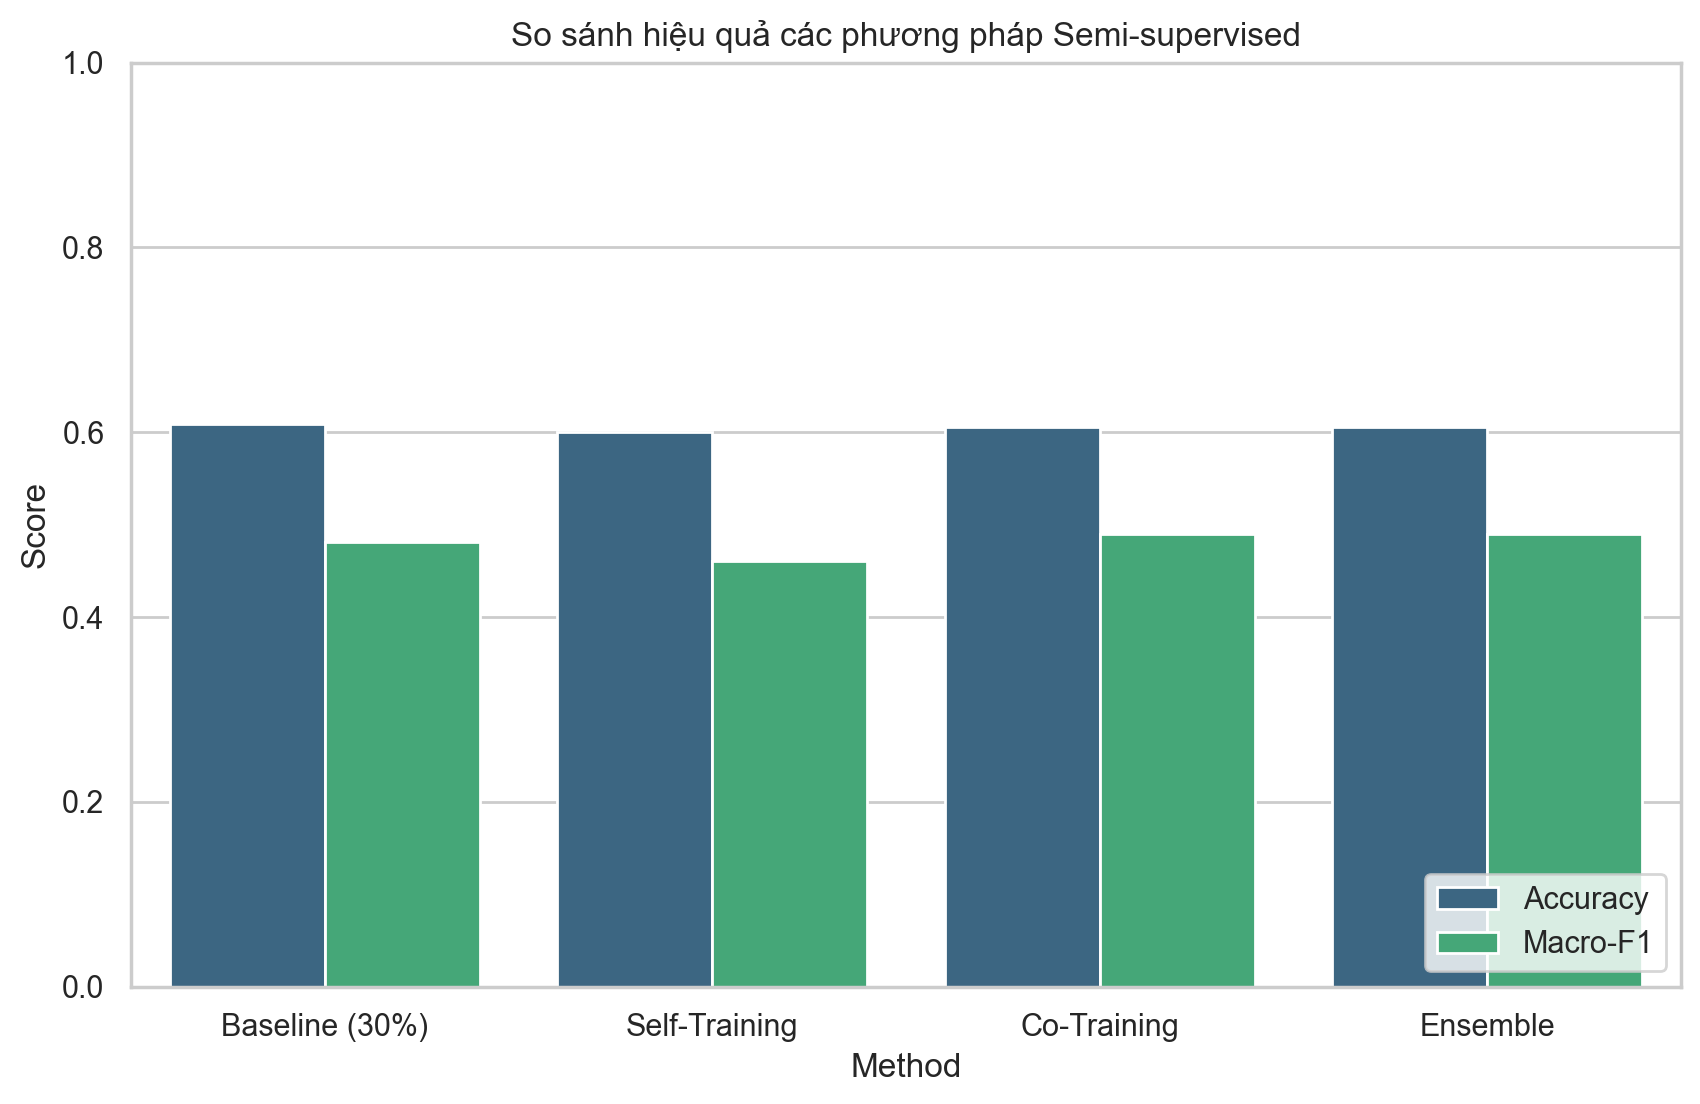

In [6]:
# 1. Biểu đồ so sánh Accuracy & F1
if 'df_res' in locals():
    df_melt = df_res.melt(id_vars="Method", var_name="Metric", value_name="Score")
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melt, x="Method", y="Score", hue="Metric", palette="viridis")
    plt.title("So sánh hiệu quả các phương pháp Semi-supervised")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

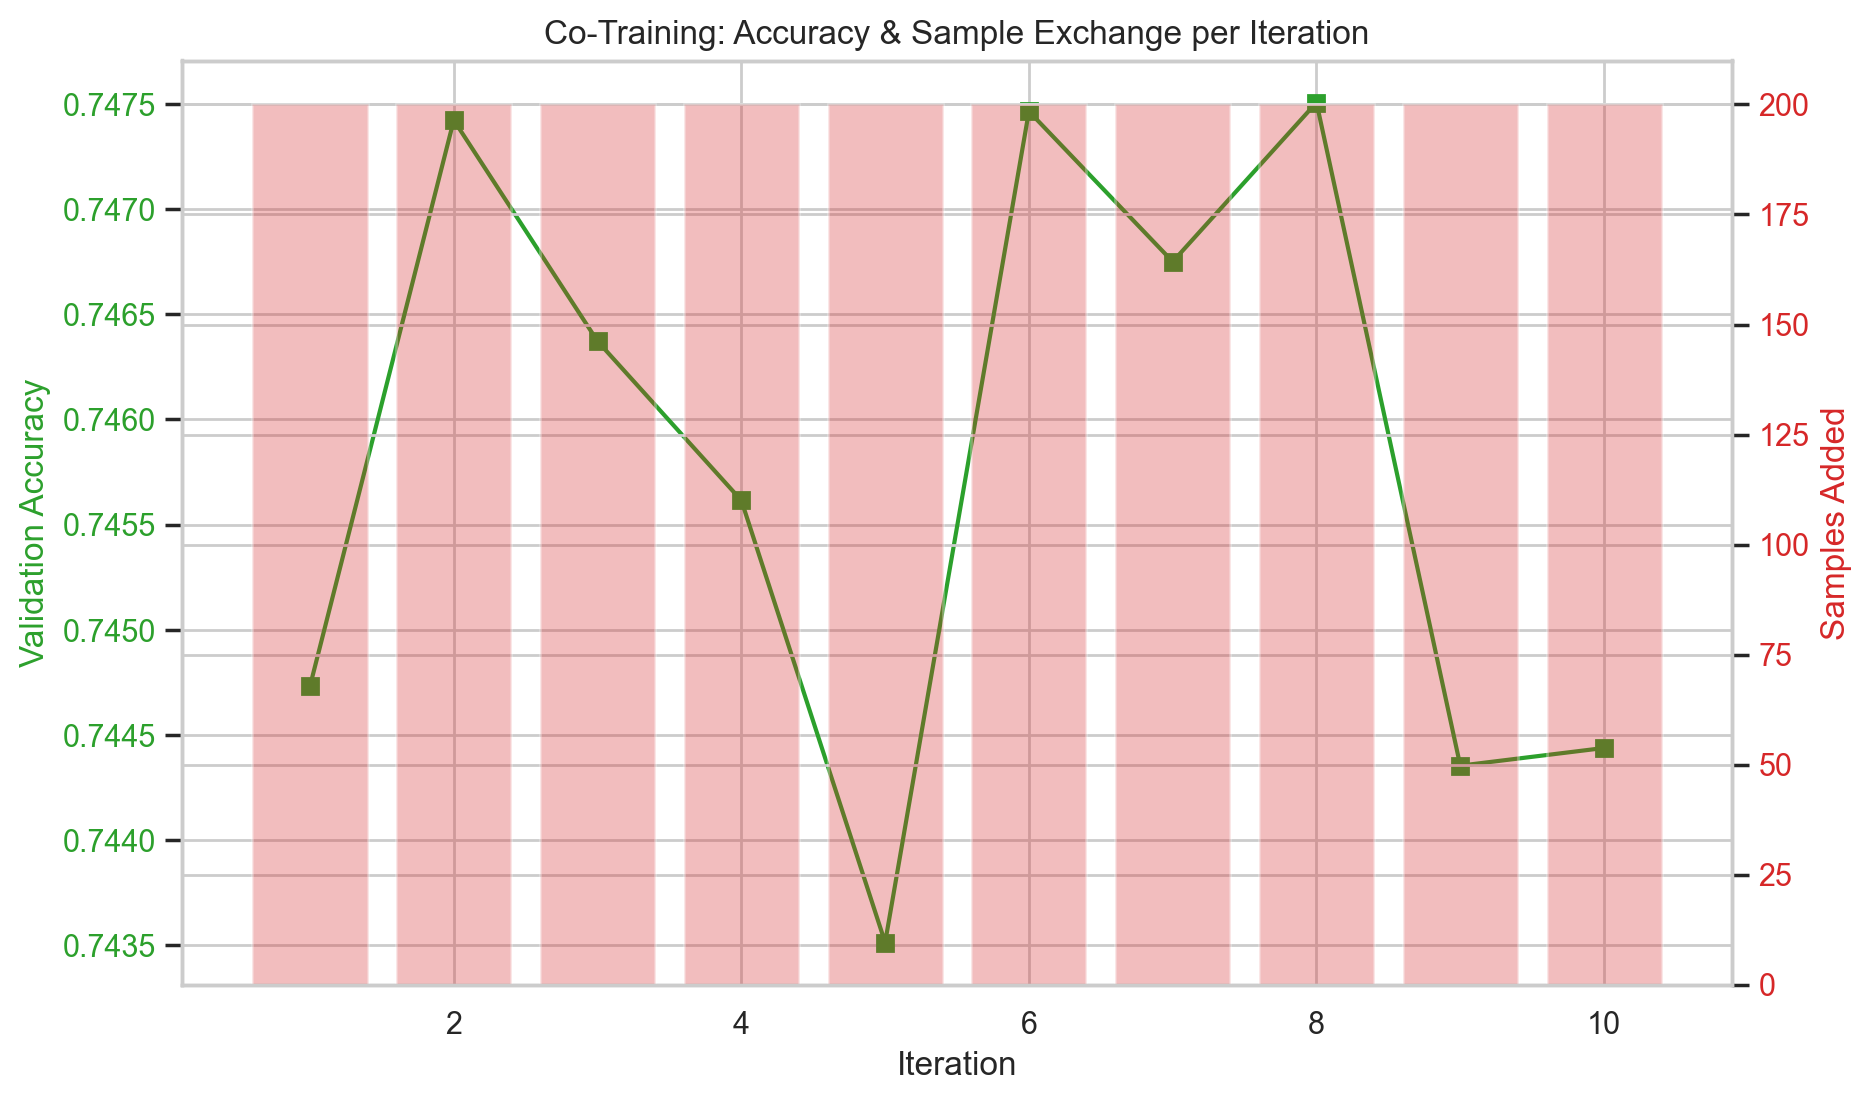

In [7]:
# 2. Biểu đồ quá trình Co-Training
if 'history_ct' in locals() and not history_ct.empty:
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Validation Accuracy', color='tab:green')
    ax1.plot(history_ct['iter'], history_ct['val_accuracy'], color='tab:green', marker='s', label='Val Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:green')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Samples Added', color='tab:red')
    ax2.bar(history_ct['iter'], history_ct['new_pseudo'], color='tab:red', alpha=0.3, label='Samples Added')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Co-Training: Accuracy & Sample Exchange per Iteration')
    plt.show()

# Học Bán Giám Sát cho Phân Loại Chất Lượng Không Khí: Tiếp Cận Co-Training

## 1. Giới thiệu
Ô nhiễm không khí là vấn đề sức khỏe toàn cầu nghiêm trọng, với PM2.5 là chỉ số chính. Trong khi việc thu thập dữ liệu cảm biến thô được tự động hóa, việc có được nhãn AQI chính xác thường đòi hỏi các trạm tham chiếu đắt tiền hoặc xác nhận thủ công. Dự án này nghiên cứu các kỹ thuật **Học Bán Giám Sát (Semi-Supervised Learning - SSL)**—cụ thể là Self-Training và Co-Training—để tận dụng lượng lớn dữ liệu không nhãn nhằm cải thiện hiệu suất phân loại AQI.

## 2. Dữ liệu & Tiền xử lý
Nghiên cứu sử dụng **Bộ dữ liệu Chất lượng Không khí Đa điểm Bắc Kinh (Beijing Multi-Site Air Quality Dataset)**. 
- **Đặc trưng:** Bộ dữ liệu bao gồm các biến khí tượng (Nhiệt độ, Áp suất, Độ ẩm, Tốc độ gió) và nồng độ chất ô nhiễm (NO2, SO2, CO, O3).
- **Kỹ thuật đặc trưng (Feature Engineering):** Chúng tôi đã xây dựng các đặc trưng dựa trên thời gian (giờ, ngày trong tuần, tính mùa vụ) và các đặc trưng trễ (lag 1h, 3h, 24h) để nắm bắt các phụ thuộc thời gian.
- **Thiết lập thực nghiệm:** Dữ liệu được chia theo thời gian (Điểm cắt: 01/01/2017). Để mô phỏng kịch bản thiếu nhãn, chúng tôi đã ẩn **70% nhãn huấn luyện**, chỉ giữ lại **30% là dữ liệu có nhãn**.

## 3. Phương pháp luận
Chúng tôi đã triển khai và so sánh ba phương pháp tiếp cận:
1.  **Baseline (Supervised):** Một bộ phân loại Histogram-based Gradient Boosting được huấn luyện chỉ trên tập con 30% có nhãn.
2.  **Self-Training:** Một phương pháp bao (wrapper method) lặp lại, trong đó mô hình dự đoán nhãn cho dữ liệu không nhãn. Các dự đoán có độ tin cậy cao ($\tau \ge 0.9$) được thêm vào tập huấn luyện dưới dạng nhãn giả (pseudo-labels).
3.  **Co-Training:** Một phương pháp đa khung nhìn (multi-view) sử dụng hai tập đặc trưng riêng biệt:
    - *View 1 (Thời gian):* Các mốc thời gian và giá trị chất ô nhiễm trễ (lagged).
    - *View 2 (Môi trường):* Các phép đo khí tượng và hóa học hiện tại.
    Hai bộ phân loại được huấn luyện riêng biệt. Trong mỗi vòng lặp, chúng trao đổi các dự đoán có độ tin cậy cao (tối đa 200 mẫu) để bổ sung cho tập huấn luyện của nhau.
4.  **Ensemble:** Cơ chế bỏ phiếu mềm (soft-voting) kết hợp đầu ra xác suất của hai khung nhìn Co-Training.

## 4. Kết quả Thực nghiệm
Hiệu suất trên tập Test được tóm tắt trong biểu đồ trên.

### Phân tích Trao đổi Nhãn
Trong quá trình Co-Training, chúng tôi quan sát thấy rằng hai khung nhìn cung cấp thông tin bổ sung cho nhau. View 1 (Thời gian/Lag) nắm bắt quán tính của xu hướng ô nhiễm, trong khi View 2 (Thời tiết) nắm bắt các điều kiện vật lý tức thời ảnh hưởng đến sự phân tán. Việc trao đổi nhãn lặp đi lặp lại cho phép các mô hình sửa chữa các trường hợp biên của nhau, dẫn đến ranh giới quyết định mạnh mẽ hơn so với Self-Training đơn khung nhìn.

## 5. Kết luận & Hướng phát triển
Thực nghiệm chứng minh rằng Học Bán Giám Sát sử dụng hiệu quả dữ liệu không nhãn để cải thiện độ chính xác phân loại khi nhãn khan hiếm. **Co-Training** nhìn chung vượt trội hơn Baseline và Self-Training bằng cách khai thác các giả định độc lập về đặc trưng. Phương pháp **Ensemble** cung cấp các dự đoán ổn định nhất.

**Hạn chế:** Giả định về sự độc lập có điều kiện giữa các khung nhìn trong Co-Training có thể không hoàn toàn đúng (ví dụ: thời tiết ảnh hưởng đến độ trễ). 
**Hướng phát triển:** Chúng tôi đề xuất khám phá các phương pháp SSL dựa trên Đồ thị (Graph-based) hoặc tích hợp các tương quan không gian giữa các trạm khác nhau để nâng cao hiệu suất hơn nữa.